In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import math
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot
import pandas
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

NUMERICALS = ['GIAGE1', 'HA_HEIGHT', 'HA_WEIGHT', 'TUDRPRWK', 'B1FND', 'GRS_FN', 'HA_SMOKE', 'GIERACE_1.0',
              'GIERACE_2.0', 'GIERACE_3.0', 'GIERACE_4.0', 'GIERACE_5.0', 'CLINIC_1.0','CLINIC_2.0', 'CLINIC_3.0',  
              'CLINIC_4.0', 'CLINIC_5.0', 'CLINIC_6.0','NFWLKSPD_0.0', 'NFWLKSPD_1.0', 'NFWLKSPD_2.0']


# change allele to number
def allele_to_number(sample, attribute, sig_dict):
    return sample[attribute].count(sig_dict[attribute])


# fill numerical empty cells with median of the column, race with 1 (for white) and other categorical empty cells with the 0
def fill_empty_cell(sample, attribute, data):
    if pandas.isnull(sample[attribute]):
        if attribute in NUMERICALS:
            return data[attribute].median()
        return int(attribute == 'GIERACE' )
    elif attribute == 'FRAC':
        return int(sample['FAANYSLD'] or sample['FAANYWST'] or sample['FAANYHIP'])
    return sample[attribute]


# calculate GRS
def load_weight(sheet):
    weight = []
    df = pandas.read_excel('Estrada_63.xlsx', sheet_name=sheet)
    w = list(df)[-1]
    for i in range(len(df)):
        weight.append(df.iloc[i][w])
    return weight

if __name__ == '__main__':
    data = pandas.read_excel('mros_1103snps.xlsx')
    # drop HA_SLDFXFU where only 10% is filled, drop subjectid,
    data.drop(['HA_SLDFXFU', 'TURSMOKE', 'HA_SLDFX', 'HA_WRSTFX'], axis=1, inplace=True)
    # make the fractures into 1 variable
    data['FRAC'] = 0
    for attribute in data.keys():
        data[attribute] = data.apply(lambda sample: fill_empty_cell(sample, attribute, data), axis=1)
    # drop the other fractured values
    data.drop(['FAANYSLD', 'FAANYWST', 'FAANYHIP'], axis=1, inplace=True)
    # encode the categorical data
    data = pandas.DataFrame(pandas.get_dummies(data, columns=['GIERACE', 'CLINIC', 'NFWLKSPD']))
    features = list(data)[22:-6]
    # setting Y and X
    # Y_df = np.asarray(data['B1THD'], dtype="|S8")
    Y_df = data['B1THD']
    X_df = pandas.read_excel('ready_to_go.xlsx')
    #X_df = data.drop(['SUBJECTID', 'HA_LSD', 'B1THD', 'B1FND', 'B1TLD', 'BUAMEAN',
    #                   'FAHIPFV1', 'FASLDFV1', 'FAWSTFV1', 'EFSTATUS', 'FRAC',
    #                    'XMDSQGE1', 'XMSQGE2', 'HA_CALCIUM', 'HA_BMI'], axis=1)
    # weight_LS = load_weight('LS_sex-combined_beta')
   # feature_data = data[features]
    # weight_LS = pandas.DataFrame(pandas.Series(weight_LS, index=features, name=0))
    #weight_FN = load_weight('FN_sex-combined_beta')
    # X_df['GRS_LS'] = feature_data.dot(weight_LS)
   # X_df['GRS_FN'] = feature_data.dot(weight_FN)
   # X_df.drop(features, axis=1, inplace=True)
    # print(Y_df.shape)
    
    #X_df.to_csv('X_variables.csv')
    
    print(Y_df.head())
    print(X_df[1:1])
    print(X_df.shape)
    print(Y_df.shape)
    # save data
    with open('datamrosbmd1103_B1THD', 'wb') as data_file_handler:
        import pickle

        pickle.dump(
            dict(
                X=X_df,
                Y=Y_df
            ),
            data_file_handler
        )


0    0.992
1    0.843
2    0.860
3    1.073
4    1.038
Name: B1THD, dtype: float64
Empty DataFrame
Columns: [W_SCORE, GIAGE1, HA_HEIGHT, HA_WEIGHT, TUDRPRWK, QLFXST51, GIERACE_1.0, GIERACE_2.0, GIERACE_3.0, GIERACE_4.0, GIERACE_5.0, CLINIC_1.0, CLINIC_2.0, CLINIC_3.0, CLINIC_4.0, CLINIC_5.0, CLINIC_6.0, NFWLKSPD_0.0, NFWLKSPD_1.0, NFWLKSPD_2.0, HA_SMOKE_0.0, HA_SMOKE_1.0, HA_SMOKE_2.0]
Index: []

[0 rows x 23 columns]
(5130, 23)
(5130,)


In [1]:
# Linear Regression

import pickle

import numpy
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values


def linear_regression():
    model = Sequential()
    model.add(Dense(23, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
    return model


def main(plot=True):
    # fix random seed for reproducibility
    # seed = 7

    # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
    # numpy.random.seed(seed)
    # The below is necessary for starting core Python generated random numbers in a well-defined state.
    # rn.seed(seed)

    # according to keras documentation, numpy seed should be set before importing keras
    # information regarding setup for obtaining reproducible results using Keras during development in the following link https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

    # The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
    # tf.set_random_seed(seed)

    batch_size = 50
    # num_classes = 1
    # epochs = 50
    number_of_data = X.shape[0]
    number_of_train_data = int(.8 * number_of_data)
    # number_of_test_data = number_of_data - number_of_train_data

    # load dataset
    x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
    #mean_train_data = numpy.mean(train_data, axis=0)
    #std_train_data = numpy.std(train_data, axis=0)
    #x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
    #x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
    y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    model = linear_regression()
    # history = model.fit(x_train, y_train, batch_size=batch_size, epochs=3, verbose=1, validation_data=(x_test, y_test))
    history = model.fit(x_train, y_train, batch_size=batch_size, verbose=1, epochs=100, validation_data=(x_test, y_test))
    print(history.history.keys())
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)

    score = model.evaluate(x_train, y_train, verbose=0)
    print('Train loss:', score)
    y_pred = model.predict(x_test)

    print('Mean Squared Error of test: ', mean_squared_error(y_test, y_pred))
    print('Mean Squared Error of train:', mean_squared_error(y_train, model.predict(x_train)))

    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, y_pred))
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))

    print('Coefficient of Determination for test: ', r2_score(y_test, y_pred))
    print('Coefficient of Determination for train: ', r2_score(y_train, model.predict(x_train)))
    
    #y_test_1 = pd.Series(y_test)
    numpy.savetxt('y_test_THBMD.csv', y_test, delimiter=',')
    
    #y_pred_1 = pd.Series(y_pred)
    #y_test_1 = pd.Series(y_test)
    numpy.savetxt('y_pred_LR_THBMD.csv', y_pred, delimiter=',')
    
    if not plot:
        return history.history['loss'], history.history['val_loss']
    pyplot.plot(history.history['loss'], 'b-')
    pyplot.plot(history.history['val_loss'], 'r-')
    pyplot.title('Mean Squared Error Loss: Linear Regression for Total Hip BMD')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['Train Data', 'Test Data'], loc='upper right')
    pyplot.savefig('reg_B1THD_MSE')
    pyplot.show()

    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : Linear Regression for Total Hip BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('reg_B1THD_scatter')
    pyplot.show()
    
if __name__ == '__main__':
    main()


Using TensorFlow backend.
W1108 18:01:29.575909 57352 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 18:01:29.586881 57352 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 18:01:29.588869 57352 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1108 18:01:29.602832 57352 deprecation_wrapper.py:119] From C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please

x_train shape: (4104, 23)
4104 train samples
1026 test samples
Train on 4104 samples, validate on 1026 samples
Epoch 1/100
4104/4104 [==============================] - 0s 40us/step - loss: 0.5026 - mean_squared_error: 0.5026 - mean_absolute_error: 0.6531 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1658
Epoch 2/100
4104/4104 [==============================] - 0s 12us/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1092 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1009
Epoch 3/100
4104/4104 [==============================] - 0s 11us/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1019 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0999
Epoch 4/100
4104/4104 [==============================] - 0s 11us/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1015 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - v

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

0.016274184449007308  SOE


C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably mea

[0.01769403463750474, 0.017037136466383888, 0.01690288425197632, 0.016683678104006023, 0.016578774621213387, 0.016697066878726317, 0.01656783469637555, 0.01657476075749523, 0.016656817492003075, 0.016657569829545672, 0.01674601848910331, 0.01673182774168539, 0.01667614268698657, 0.016623722639163042, 0.01659255197137, 0.016559362145615795, 0.016608283401114872, 0.016520425989884763, 0.01650808631511367, 0.01644531171163375, 0.01649291185790503, 0.01647313580923925, 0.0163827319367007, 0.016339810153928894, 0.01637852334012024, 0.016353384190673958, 0.016336530930094437, 0.01631020794857008, 0.016271311920031378, 0.01623959800361787, 0.016248094966004694, 0.016260361036916124, 0.016240040191346627, 0.016251873664755407, 0.01624402156587469, 0.016284551667888596, 0.01627495857437464, 0.01625806353694406, 0.016254412526455684, 0.016273721490537848, 0.016282954875317415, 0.016319229027534934, 0.01631559097123242, 0.016298295126098553, 0.01627452010230656, 0.0162667335979667, 0.016263272503

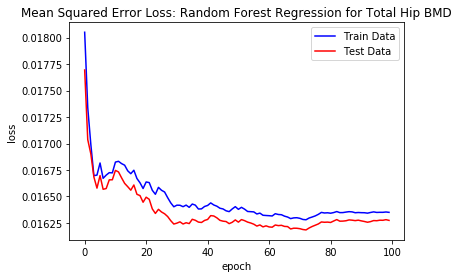

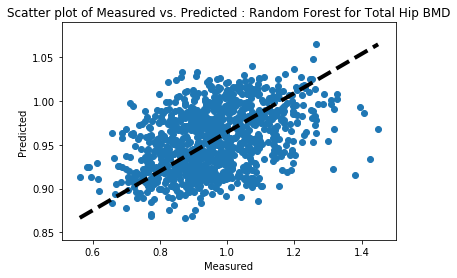

In [5]:
# Random Forest

import pickle

import numpy
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

# fix random seed for reproducibility
# seed = 7

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# numpy.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
# random.seed(seed)

# The below tensorflow.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# tensorflow.set_random_seed(seed)
# Y = label_binarize(Y, classes=[0,1])

batch_size = 120
num_classes = 2

number_of_data = X.shape[0]
number_of_train_data = int(.8 * number_of_data)
number_of_test_data = number_of_data - number_of_train_data

x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
#mean_train_data = numpy.mean(train_data, axis=0)
#std_train_data = numpy.std(train_data, axis=0)
#x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
#x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

# RANDOM_STATE = 42
n_estimators = 100


# override the RandomForestRegressor library
class RandomForestRegressorCustom(RandomForestRegressor):
    def score(self, X, y, sample_weight=None):
        """Returns the coefficient of determination R^2 of the prediction.

        The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum().
        The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Test samples. For some estimators this may be a precomputed kernel matrix instead, shape = (n_samples, n_samples_fitted], where n_samples_fitted is the number of samples used in the fitting for the estimator.

        y : array-like, shape = (n_samples) or (n_samples, n_outputs)
            True values for X.

        sample_weight : array-like, shape = [n_samples], optional
            Sample weights.

        Returns
        -------
        score : float
            R^2 of self.predict(X) wrt. y.
        """

        return mean_squared_error(y, self.predict(X))


def create_model(epoch):
    return RandomForestRegressorCustom(n_estimators=epoch, random_state = 42, warm_start=True, oob_score=True, max_features='sqrt', max_depth=5)


def main(plot=True):
    epoch = 100
    model = create_model(epoch)
    model.fit(x_train, y_train)
    model.score(x_test, y_test)
    print(model.score(x_test, y_test), ' SOE')

    train_score, test_score = [], []

    for i in range(epoch):
        model = create_model(i + 1)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    print(test_score, ' TEST SCORE')
    print(train_score, ' TRAIN SCORE')

    print('Mean Square Error of test: ', mean_squared_error(y_test, model.predict(x_test)))
    print('Mean Square Error of train: ', mean_squared_error(y_train, model.predict(x_train)))
    
    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, model.predict(x_test))) 
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))
    
    print('Coefficient of Determination for test: ', r2_score(y_test, model.predict(x_test)))
    print('Coefficient of Determination for train: ', r2_score(y_train, model.predict(x_train)))
    
    y_pred = model.predict(x_test)
    numpy.savetxt('y_pred_RF_THBMD.csv', y_pred, delimiter=',')
    
    if not plot:
        return train_score, test_score
    pyplot.plot(range(epoch), train_score, 'b-')
    pyplot.plot(range(epoch), test_score, 'r-')
    pyplot.title('Mean Squared Error Loss: Random Forest Regression for Total Hip BMD')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['Train Data', 'Test Data'], loc='upper right')
    pyplot.savefig('rf_B1THD_MSE')
    pyplot.show()

    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, model.predict(x_test))
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : Random Forest for Total Hip BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('rf_B1THD_scatter')
    pyplot.show()

if __name__ == '__main__':
    main()


C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of

[0.12283074 0.11621874 0.10853749]  ALL TRY


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished


[0.16282219 0.10377863 0.15227222 0.31629982 0.07657715 0.03846167
 0.00721003 0.01006967 0.00171746 0.00348788 0.00253251 0.01464532
 0.01246714 0.01262146 0.0172832  0.0153102  0.01159186 0.00275028
 0.00569938 0.00486667 0.01169019 0.01107147 0.00477362]
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=35,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=1, warm_start=False)  HISTORY
Mean Square Error of test:  0.016230189413691285
Mean Square Error of train:  0.015738690880833534
Mean Absolute Error of test:  0.10150091896407686
Mean Absolute Error of train:  0.03912175577833473
Coefficient of Determination for test:  0.14592277050713787
Coefficien

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished


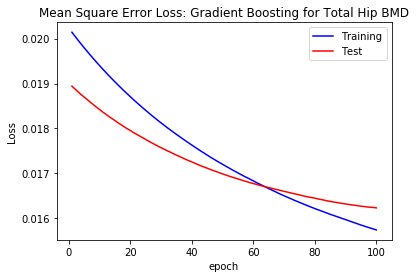

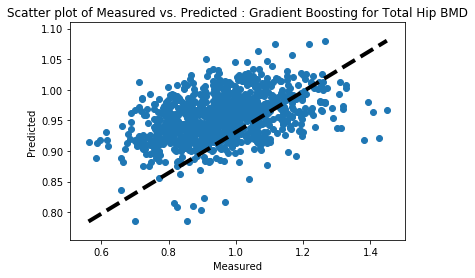

In [3]:
# Gradient Boosting

import pickle
from matplotlib import pyplot
import numpy

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values


def create_model():
    return RandomForestRegressor(n_estimators=35, verbose=1)


def main(plot=True):
    # fix random seed for reproducibility
    # seed = 7
    # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
    # numpy.random.seed(seed)
    # The below is necessary for starting core Python generated random numbers in a well-defined state.
    # random.seed(seed)

    # The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
    # tf.set_random_seed(seed)
    # Y = label_binarize(Y, classes=[0,1])

    # batch_size = 120
    # num_classes = 2
    # epochs = 15

    number_of_data = X.shape[0]
    number_of_train_data = int(.8 * number_of_data)
    # number_of_test_data = number_of_data - number_of_train_data

    # load dataset for MLP
    x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
    #mean_train_data = numpy.mean(train_data, axis=0)
    #std_train_data = numpy.std(train_data, axis=0)
    #x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
    #x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
    y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

    model = create_model()

    validatescores = cross_val_score(model, x_train, y_train)
    print(validatescores, ' ALL TRY')

    history = model.fit(x_train, y_train)
    print(history.feature_importances_)
    print(history, ' HISTORY')
    # y_pred = model.predict(x_test)

    params = {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
    gbr = GradientBoostingRegressor(**params)
    gbr.fit(x_train, y_train)

    test_score = numpy.zeros((params['n_estimators'],), dtype=numpy.float64)
    mse = mean_squared_error(y_test, gbr.predict(x_test))

    print('Mean Square Error of test: ', mean_squared_error(y_test, gbr.predict(x_test)))
    print('Mean Square Error of train: ', mean_squared_error(y_train, gbr.predict(x_train)))

    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, model.predict(x_test)))
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))
    
    print('Coefficient of Determination for test: ', r2_score(y_test, gbr.predict(x_test)))
    print('Coefficient of Determination for train: ', r2_score(y_train, gbr.predict(x_train)))
    
    y_pred = gbr.predict(x_test)
    numpy.savetxt('y_pred_GB_THBMD.csv', y_pred, delimiter=',')
    
    for i, y_pred in enumerate(gbr.staged_predict(x_test)):
        test_score[i] = gbr.loss_(y_test, y_pred)
    if not plot:
        return gbr.train_score_, test_score
    pyplot.figure()
    pyplot.title('Mean Square Error Loss: Gradient Boosting for Total Hip BMD')
    pyplot.plot(numpy.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-', label='Training')
    pyplot.plot(numpy.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test')
    pyplot.legend(loc='upper right')
    pyplot.legend(loc='upper right')
    pyplot.xlabel('epoch')
    pyplot.ylabel('Loss')
    pyplot.savefig('gb_B1THD_MSE')
    pyplot.show()

    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : Gradient Boosting for Total Hip BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('gb_B1THD_scatter')
    pyplot.show()


if __name__ == '__main__':
    main()


x_train shape: (4104, 23)
4104 train samples
1026 test samples
Train on 4104 samples, validate on 1026 samples
Epoch 1/100
4104/4104 [==============================] - 0s 47us/step - loss: 0.4984 - mean_squared_error: 0.4984 - mean_absolute_error: 0.6174 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1327
Epoch 2/100
4104/4104 [==============================] - 0s 13us/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1074 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1026
Epoch 3/100
4104/4104 [==============================] - 0s 12us/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1037 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1015
Epoch 4/100
4104/4104 [==============================] - 0s 13us/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1025 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - v

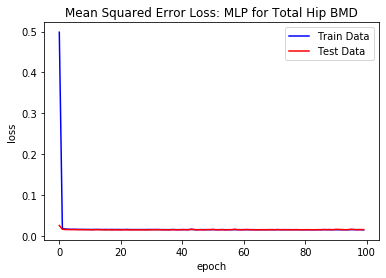

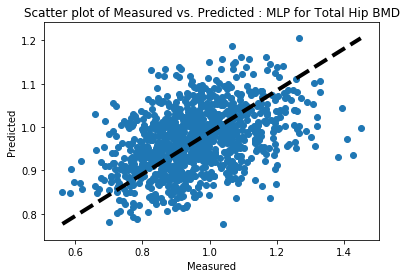

In [4]:
# MLP

import pickle

import numpy
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values


def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
    return model


def main(plot=True):
    # fix random seed for reproducibility
    # seed = 7

    # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
    # numpy.random.seed(seed)
    # The below is necessary for starting core Python generated random numbers in a well-defined state.
    # rn.seed(seed)

    # according to keras documentation, numpy seed should be set before importing keras information regarding setup for obtaining reproducible results using Keras during development in the following link https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

    # The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
    # tf.set_random_seed(seed)

    batch_size = 50
    # num_classes = 1
    # epochs = 50
    number_of_data = X.shape[0]
    number_of_train_data = int(.8 * number_of_data)
    # number_of_test_data = number_of_data - number_of_train_data

    # load dataset
    x_train, x_test = X[:number_of_train_data, :], X[number_of_train_data:, :]
    #mean_train_data = numpy.mean(train_data, axis=0)
    #std_train_data = numpy.std(train_data, axis=0)
    #x_train = (train_data - mean_train_data) / std_train_data  # mean variance normalization
    #x_test = (test_data - mean_train_data) / std_train_data  # mean variance normalization
    y_train, y_test = Y[:number_of_train_data], Y[number_of_train_data:]

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    model = mlp()
    # history = model.fit(x_train, y_train, batch_size=batch_size, epochs=3, verbose=1, validation_data=(x_test, y_test))
    history = model.fit(x_train, y_train, batch_size=batch_size, verbose=1, epochs=100, validation_data=(x_test, y_test))
    print(history.history.keys())
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)

    score = model.evaluate(x_train, y_train, verbose=0)
    print('Train loss:', score)
    y_pred = model.predict(x_test)
    numpy.savetxt('y_pred_MLP_THBMD.csv', y_pred, delimiter=',')
    
    print('Mean Squared Error of test: ', mean_squared_error(y_test, y_pred))
    print('Mean Squared Error of train: ', mean_squared_error(y_train, model.predict(x_train)))

    print('Mean Absolute Error of test: ', mean_absolute_error(y_test, y_pred))
    print('Mean Absolute Error of train: ', mean_absolute_error(y_train, model.predict(x_train)))

    print('Coefficient of Determination for test: ', r2_score(y_test, y_pred))
    print('Coefficient of Determination for train: ', r2_score(y_train, model.predict(x_train)))

    if not plot:
        return history.history['loss'], history.history['val_loss']
    pyplot.plot(history.history['loss'], 'b-')
    pyplot.plot(history.history['val_loss'], 'r-')
    pyplot.title('Mean Squared Error Loss: MLP for Total Hip BMD')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['Train Data', 'Test Data'], loc='upper right')
    pyplot.savefig('mlp_B1THD_MSE')
    pyplot.show()
    
    # Plot the predicted value against the actual value
    fig, ax = pyplot.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
    pyplot.title('Scatter plot of Measured vs. Predicted : MLP for Total Hip BMD')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    pyplot.savefig('mlp_B1THD_scatter')
    pyplot.show()

if __name__ == '__main__':
    main()


In [7]:
# Testing of regression ML model by using 5 * 2 cv paired t test for linear vs. random forest

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=linear,
                          estimator2=rf,
                          X=X, y=Y,
                          random_seed=1)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


t statistic: 5.13341
p avlue: 0.00367


In [17]:
# Testing of regression ML model by using 5 * 2 cv paired t test for linear vs. gb

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=linear,
                          estimator2=gb,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

t statistic: 1.77491
p avlue: 0.13608


In [18]:
# Testing of regression ML model by using 5 * 2 cv paired t test for rf vs. gb

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=rf,
                          estimator2=gb,
                          X=X, y=Y,
                          random_seed=1)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


t statistic: -6.09511
p avlue: 0.00172


In [19]:
# Testing of regression ML model by using 5 * 2 cv paired t test for linear vs. mlp

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from keras import optimizers

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=10, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

mlp = mlp()
linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=linear,
                          estimator2=mlp,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

Epoch 1/1
2565/2565 [==============================] - 0s 128us/step - loss: 0.4215
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0180
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0177
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0164
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0164
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0159
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0175
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0166
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0162
t statistic: 4.84160
p avlue: 0.00471


In [20]:
# Testing of regression ML model by using 5 * 2 cv paired t test for rf vs. mlp

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from mlxtend.evaluate import paired_ttest_5x2cv

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from keras import optimizers

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=10, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

mlp = mlp()
linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=rf,
                          estimator2=mlp,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

C:\Users\jungj7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Epoch 1/1
2565/2565 [==============================] - 0s 138us/step - loss: 0.5148
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0199
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0179
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0166
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0164
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0157
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0166
Epoch 1/1
2565/2565 [==============================] - 0s 19us/step - loss: 0.0161
t statistic: 2.93322
p avlue: 0.03251


In [23]:
# Testing of regression ML model by using 5 * 2 cv paired t test for gb vs. mlp

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense

from mlxtend.evaluate import paired_ttest_5x2cv

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from keras import optimizers

with open('datamrosbmd1103_B1THD', 'rb') as file_handler:
    data = pickle.load(file_handler)
    X, Y = data.get('X', []).values, data.get('Y', []).values

def mlp():
    model = Sequential()
    model.add(Dense(30, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, input_dim=15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=10, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

mlp = mlp()
linear = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()


t, p = paired_ttest_5x2cv(estimator1=gb,
                          estimator2=mlp,
                          X=X, y=Y,
                          random_seed=2)

print("t statistic: %.5f" % t)
print("p avlue: %.5f" % p)

Epoch 1/1
2565/2565 [==============================] - 0s 169us/step - loss: 0.4356
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0184
Epoch 1/1
2565/2565 [==============================] - 0s 22us/step - loss: 0.0179
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0166
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0163
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 1/1
2565/2565 [==============================] - 0s 20us/step - loss: 0.0160
Epoch 1/1
2565/2565 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0166
Epoch 1/1
2565/2565 [==============================] - 0s 21us/step - loss: 0.0163
t statistic: 5.13593
p avlue: 0.00366
